# 迷你项目：蒙特卡洛方法

在此 notebook 中，你将自己编写很多蒙特卡洛 (MC) 算法的实现。

虽然我们提供了一些起始代码，但是你可以删掉这些提示并从头编写代码。

### 第 0 部分：探索 BlackjackEnv

请使用以下代码单元格创建 [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) 环境的实例。

In [1]:
import gym
env = gym.make('Blackjack-v0')

每个状态都是包含以下三个元素的 3 元组：
- 玩家的当前点数之和 $\in \{0, 1, \ldots, 31\}$，
- 庄家朝上的牌点数之和  $\in \{1, \ldots, 10\}$，及
- 玩家是否有能使用的王牌（`no` $=0$、`yes` $=1$）。

智能体可以执行两个潜在动作：

In [2]:
STICK = 0
HIT = 1

通过运行以下代码单元格进行验证。

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


执行以下代码单元格以按照随机策略玩二十一点。

（*代码当前会玩三次二十一点——你可以随意修改该数字，或者多次运行该单元格。该单元格旨在让你体验当智能体与环境互动时返回的输出结果。*）

In [4]:
for i_episode in range(4):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(20, 7, False)
End game! Reward:  1.0
You won :)

(20, 3, False)
End game! Reward:  1.0
You won :)

(12, 8, False)
(16, 8, False)
End game! Reward:  -1.0
You lost :(

(13, 3, False)
End game! Reward:  -1.0
You lost :(



### 第 1 部分：MC 预测 - 状态值

在此部分，你将自己编写 MC 预测的实现（用于估算状态值函数）。

我们首先将研究以下策略：如果点数之和超过 18，玩家将始终停止出牌。函数  `generate_episode_from_limit` 会根据该策略抽取一个阶段。 

该函数会接收以下**输入**：
- `bj_env`：这是 OpenAI Gym 的 Blackjack 环境的实例。

它会返回以下**输出**：
- `episode`：这是一个（状态、动作、奖励）元组列表，对应的是 $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$， 其中 $T$ 是最终时间步。具体而言，`episode[i]` 返回 $(S_i, A_i, R_{i+1})$， `episode[i][0]`、`episode[i][1]`和 `episode[i][2]` 分别返回 $S_i$, $A_i$和 $R_{i+1}$。

In [5]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

执行以下代码单元格以按照该策略玩二十一点。 

（*代码当前会玩三次二十一点——你可以随意修改该数字，或者多次运行该单元格。该单元格旨在让你熟悉  `generate_episode_from_limit` 函数的输出结果。*）

In [6]:
for i in range(3):
    print(generate_episode_from_limit(env))

[((15, 9, False), 1, -1)]
[((11, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[((13, 10, False), 1, 0), ((18, 10, False), 1, -1)]


现在你已经准备好自己编写 MC 预测的实现了。你可以选择实现首次经历或所有经历 MC 预测；对于 Blackjack 环境，这两种技巧是对等的。

你的算法将有四个参数：
- `env`：这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `generate_episode`：这是返回互动阶段的函数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：
- `V`：这是一个字典，其中 `V[s]` 是状态 `s` 的估算值。例如，如果代码返回以下输出结果：

{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...

则状态 `(4, 7, False)` 的值估算为  `-0.38775510204081631`。

如果你不知道如何在 Python 中使用 `defaultdict`，建议查看[此源代码](https://www.accelebrate.com/blog/using-defaultdict-python/)。

In [7]:
from collections import defaultdict
import numpy as np
import sys

def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionary of lists
    returns = defaultdict(list)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        # generate an eposide
        episode = generate_episode(env)
        
        # obtain the states, actions and rewards
        states, actions, rewards = zip(*episode)
        
        # calculate the discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        # calculate the sum of the rewards following each states
        for i, state in enumerate(states):
            returns[state].append(np.sum(rewards[i:] * discounts[:-(i+1)]))
    
    # calculate the mean as the state-value function estimation
    V = {k:np.mean(v) for k, v in returns.items()}
    return V

使用以下单元格计算并绘制状态值函数估算值。 (_用于绘制值函数的代码来自[此源代码](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py)，并且稍作了修改。_）

要检查你的实现是否正确，应将以下图与解决方案 notebook **Monte_Carlo_Solution.ipynb** 中的对应图进行比较。

Episode 500000/500000.

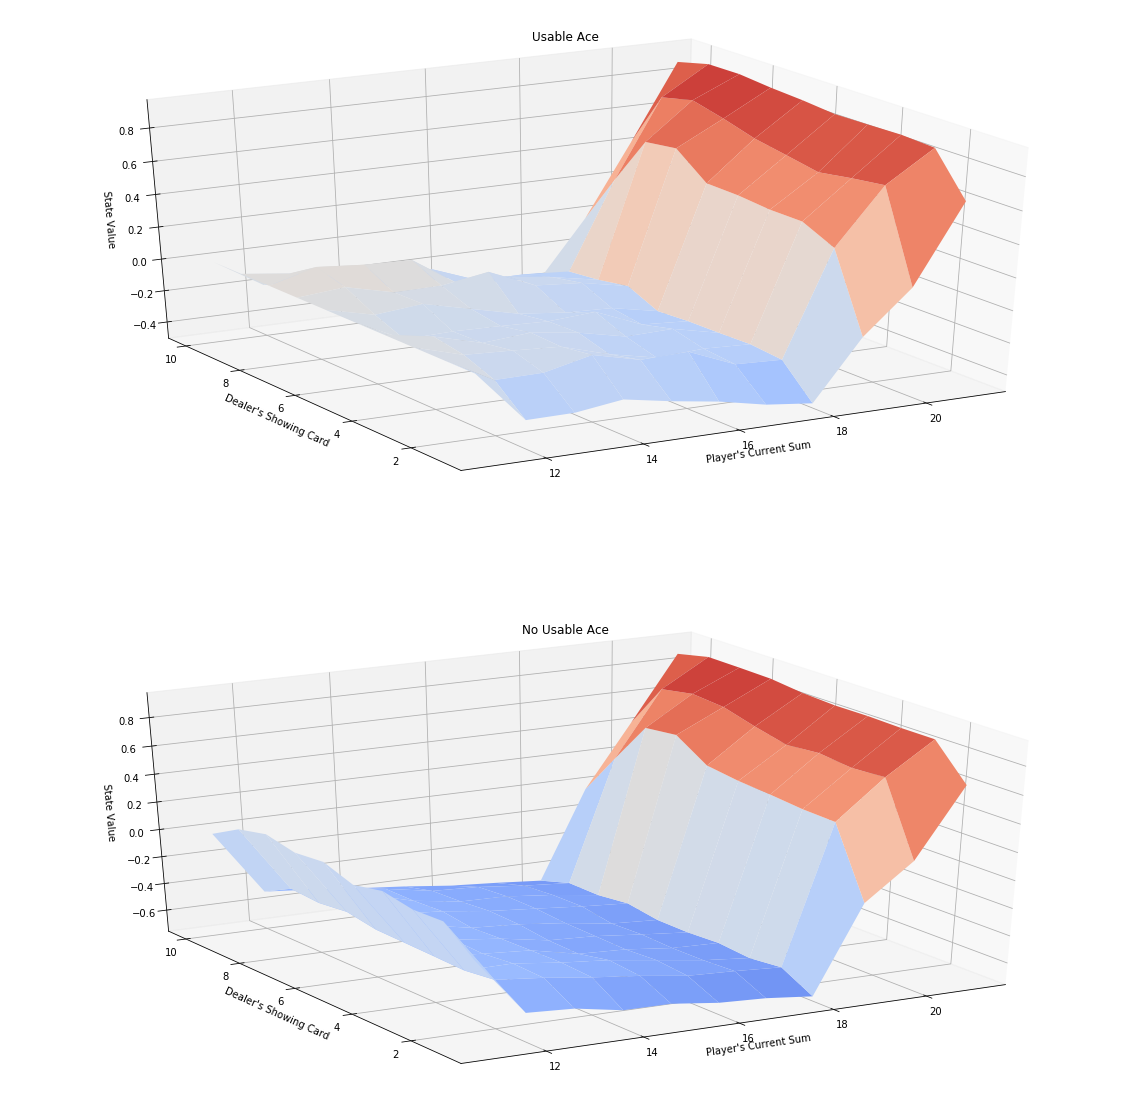

In [10]:
from plot_utils import plot_blackjack_values
%matplotlib inline

# obtain the value function
V = mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
plot_blackjack_values(V)

### 第 2 部分：MC 预测 - 动作值

在此部分，你将自己编写 MC 预测的实现（用于估算动作值函数）。  

我们首先将研究以下策略：如果点数之和超过 18，玩家将_几乎_始终停止出牌。具体而言，如果点数之和大于 18，她选择动作 `STICK` 的概率是 80%；如果点数之和不大于 18，她选择动作  `HIT` 的概率是 80%。函数 `generate_episode_from_limit_stochastic` 会根据该策略抽取一个阶段。 

该函数会接收以下**输入**：
- `bj_env`：这是 OpenAI Gym 的 Blackjack 环境的实例。

该算法会返回以下**输出结果**：
- `episode`: 这是一个（状态、动作、奖励）元组列表，对应的是 $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$， 其中 $T$ 是最终时间步。具体而言，`episode[i]` 返回 $(S_i, A_i, R_{i+1})$， `episode[i][0]`、`episode[i][1]`和 `episode[i][2]` 分别返回 $S_i$, $A_i$和 $R_{i+1}$。

In [11]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

现在你已经准备好自己编写 MC 预测的实现了。你可以选择实现首次经历或所有经历 MC 预测；对于 Blackjack 环境，这两种技巧是对等的。

你的算法将有四个参数：
- `env`: 这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `generate_episode`：这是返回互动阶段的函数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：

- `Q`：这是一个字典（一维数组），其中 `Q[s][a]` 是状态 `s` 和动作 `a` 对应的估算动作值。

In [27]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        episode = generate_episode(env)
        
        # 
        states, actions, rewards = zip(*episode)
        
        discounting = np.array([gamma**i for i in range(len(states) + 1)])
        
        F = {}
        F = defaultdict(lambda: np.zeros(env.action_space.n))
        
        
        for i, state in enumerate(states):
            if not F[state][actions[i]]:
                N[state][actions[i]] += 1
                returns_sum[state][actions[i]] += np.sum(rewards[i:]*discounting[:-(i+1)])
                Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
                F[state][actions[i]] = 1
            
#     for state, actions in N.items():
#         for i in range(len(actions)):
#             Q[state][i] = returns_sum[state][i] / N[state][i]
        
    return Q

请使用以下单元格获取动作值函数估值 $Q$。我们还绘制了相应的状态值函数。

要检查你的实现是否正确，应将以下图与解决方案 notebook **Monte_Carlo_Solution.ipynb** 中的对应图进行比较。

Episode 500000/500000.

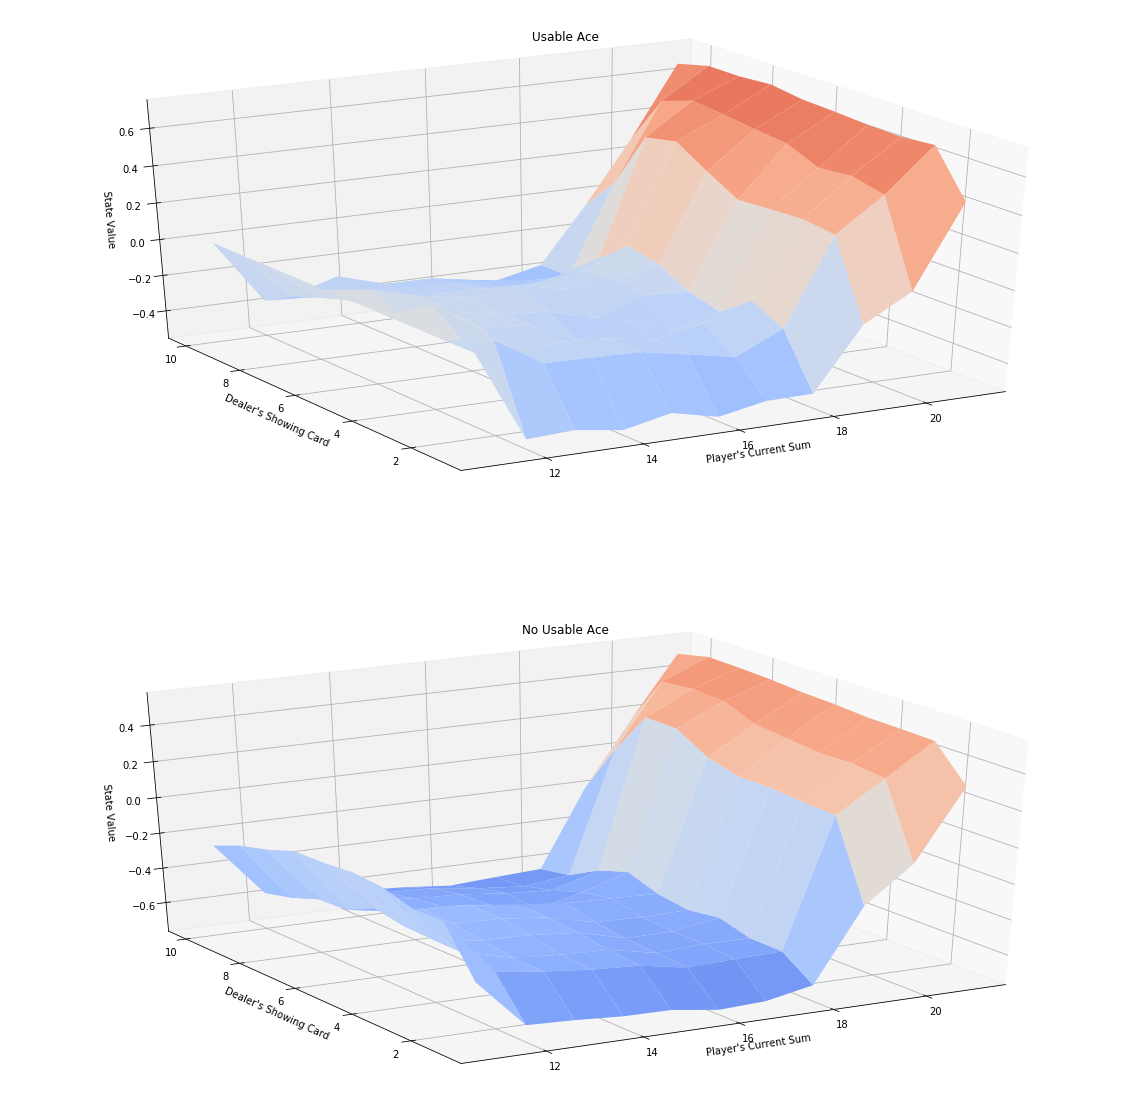

In [28]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### 第 3 部分：MC 控制 - GLIE

在此部分，你将自己编写常量-$\alpha$ MC 控制的实现。

你的算法将有四个参数：

- `env`: 这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `generate_episode`：这是返回互动阶段的函数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：

- `Q`：这是一个字典（一维数组），其中 `Q[s][a]` 是状态 `s` 和动作 `a` 对应的估算动作值。

- `policy`：这是一个字典，其中 `policy[s]` 会返回智能体在观察状态 `s` 之后选择的动作。

（_你可以随意定义其他函数，以帮助你整理代码。_）

In [76]:
def update_policy(env, epsilon, Q_s):
#     policy = defaultdict(lambda: np.zeros(env.action_space.n))
#     for state in Q.keys():
#         max_a = np.argmax(Q[state])
#         policy[state][max_a] = 1 - epsilon + epsilon / env.action_space.n
#         policy[state][1-max_a] = epsilon / env.action_space.n
    nA = env.action_space.n
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    
    return policy_s

def generate_episode_from_q(bj_env, epsilon, Q):
    episode = []
    state = bj_env.reset()
    while True:
        # probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=update_policy(bj_env, epsilon, Q[state])) if state in Q else env.action_space.sample()
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [72]:
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        # epsilon = 1 / i_episode
        epsilon = 1.0/((i_episode/8000)+1)
        
        # prob = update_policy(env, epsilon, Q[state])
        
        episode = generate_episode_from_q(env, epsilon, Q)
        
        states, actions, rewards = zip(*episode)
        
        discounts = np.array([gamma**i for i in range(len(states) + 1)])
        
        for i, state in enumerate(states):
            N[state][actions[i]] += 1
            Q[state][actions[i]] += (np.sum(rewards[i:] * discounts[:-(i+1)]) - Q[state][actions[i]]) / N[state][actions[i]]
            
    policy = {k:np.argmax(v) for k, v in Q.items()}
        
    return policy, Q

通过以下单元格获取估算的最优策略和动作值函数。

In [73]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

接着，我们将绘制相应的状态值函数。

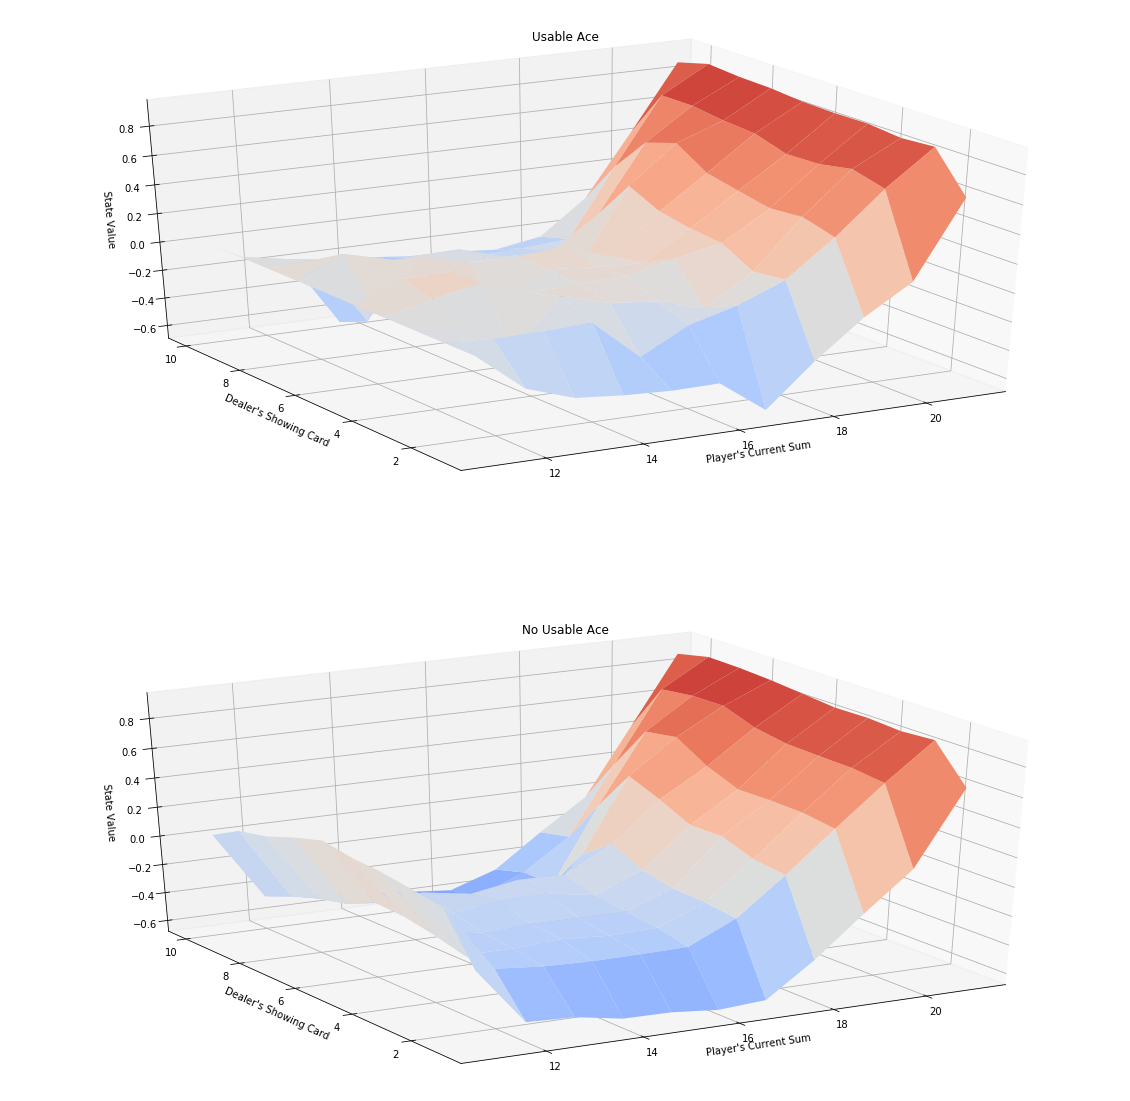

In [74]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

最后，我们将可视化估算为最优策略的策略。

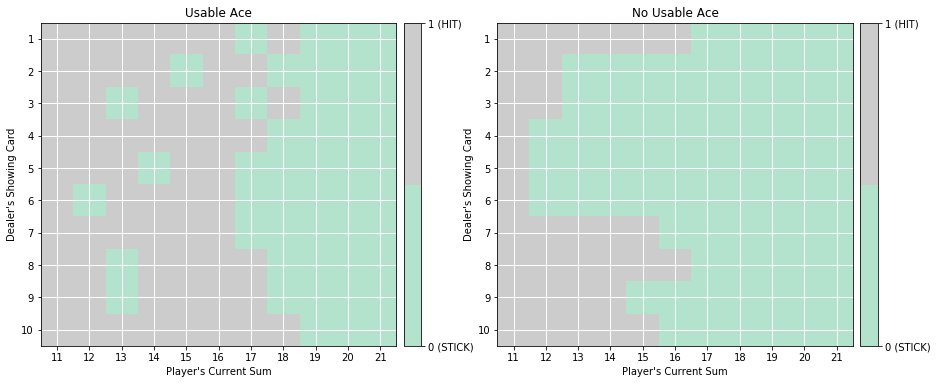

In [75]:
from plot_utils import plot_policy

# plot the policy
plot_policy(policy_glie)

**真**最优策略 $\pi_*$ 可以在该[教科书](http://go.udacity.com/rl-textbook)的第 82 页找到（下文也提供了）。请将你的最终估算值与最优策略进行比较——它们能够有多接近？如果你对算法的效果不满意，请花时间调整 $\epsilon$ 的衰减率和/或使该算法运行更多个阶段，以获得更好的结果。

![True Optimal Policy](images/optimal.png)

### 第 4 部分：MC 控制 - 常量-$\alpha$

在此部分，你将自己编写常量-$\alpha$ MC 控制的实现。  

你的算法将有三个参数：

- `env`: 这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `generate_episode`：这是返回互动阶段的函数。
- `alpha`：这是更新步骤的步长参数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：

- `Q`：这是一个字典（一维数组），其中 `Q[s][a]` 是状态 `s` 和动作 `a` 对应的估算动作值。


- `policy`：这是一个字典，其中 `policy[s]` 会返回智能体在观察状态 `s` 之后选择的动作。

（_你可以随意定义其他函数，以帮助你整理代码。_）

In [79]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        # epsilon = 1 / i_episode
        epsilon = 1.0/((i_episode/8000)+1)
        
        # prob = update_policy(env, epsilon, Q[state])
        
        episode = generate_episode_from_q(env, epsilon, Q)
        
        states, actions, rewards = zip(*episode)
        
        discounts = np.array([gamma**i for i in range(len(states) + 1)])
        
        for i, state in enumerate(states):
            # N[state][actions[i]] += 1
            Q[state][actions[i]] += alpha * (np.sum(rewards[i:] * discounts[:-(i+1)]) - Q[state][actions[i]])
            
    policy = {k:np.argmax(v) for k, v in Q.items()}
        
    return policy, Q

通过以下单元格获得估算的最优策略和动作值函数。

In [80]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 500000, 0.008)

Episode 500000/500000.

接着，我们将绘制相应的状态值函数。

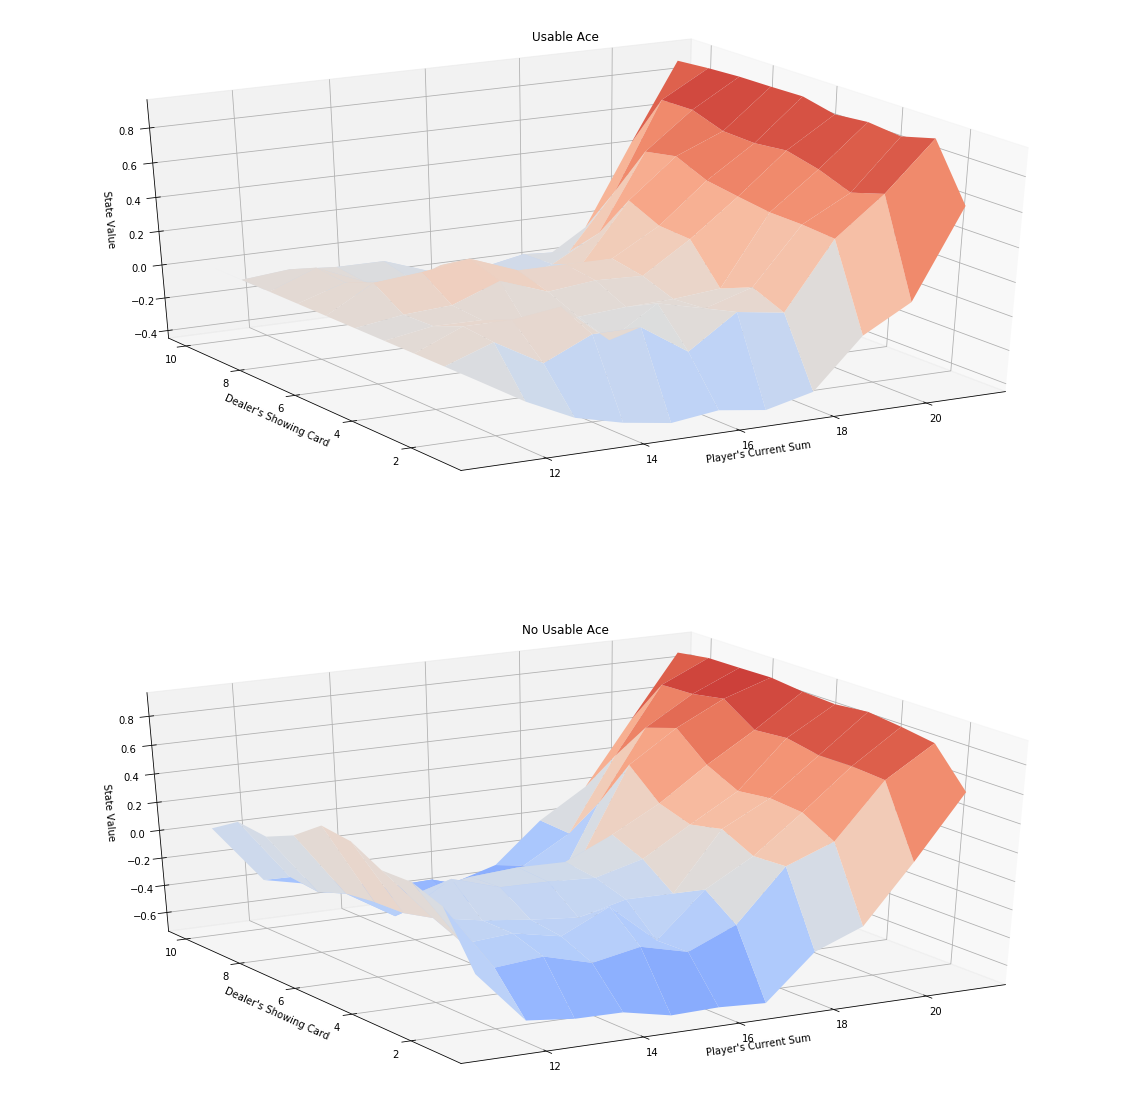

In [81]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

最后，我们将可视化估算为最优策略的策略。

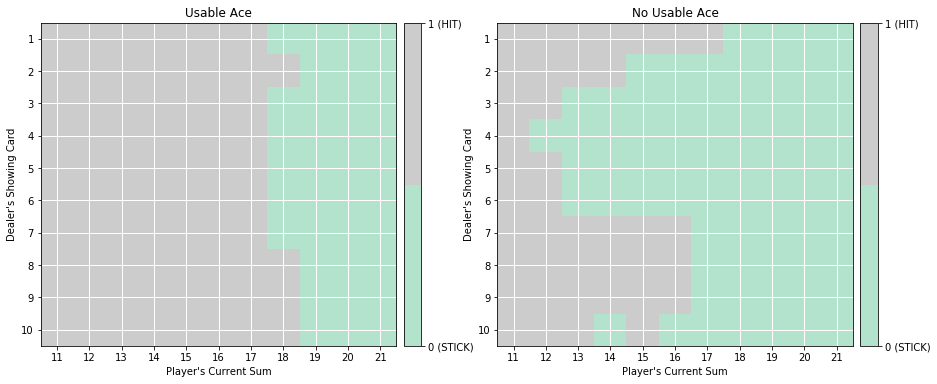

In [82]:
# plot the policy
plot_policy(policy_alpha)

**真**最优策略 $\pi_*$ 可以在该[教科书](http://go.udacity.com/rl-textbook)的第 82 页找到（下文也提供了）。请将你的最终估算值与最优策略进行比较——它们能够有多接近？如果你对算法的效果不满意，请花时间调整 $\epsilon$ 的衰减率和/或使该算法运行更多个阶段，以获得更好的结果。

![True Optimal Policy](images/optimal.png)